<a href="https://colab.research.google.com/github/hamzaasad26/DeepLearning_Assignments_i221908/blob/main/safety_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bahushruth/legalclausedataset")

print("Path to dataset files:", path)

100%|██████████| 19.4M/19.4M [00:00<00:00, 62.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bahushruth/legalclausedataset/versions/1


In [1]:



"""
Legal Clause Similarity Detection using Deep Learning
Assignment 2 - CS452
Complete implementation with two baseline architectures
"""

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [3]:
class DataPreprocessor:
    """Handles all data loading, cleaning, and preprocessing operations"""

    def __init__(self, data_path):
        self.data_path = data_path
        self.vocab = {'<PAD>': 0, '<UNK>': 1}
        self.vocab_size = 2
        self.max_length = 100

    def clean_text(self, text):
        """Clean and normalize text"""
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def load_data(self):
        """Load all CSV files and combine into single dataframe"""
        # Check if path exists
        if not os.path.exists(self.data_path):
            raise ValueError(f"Data path does not exist: {self.data_path}")

        print(f"Searching for CSV files in: {self.data_path}")

        # Try different possible locations
        csv_files = glob.glob(os.path.join(self.data_path, '*.csv'))
        if len(csv_files) == 0:
            csv_files = glob.glob(os.path.join(self.data_path, '**', '*.csv'), recursive=True)

        print(f"Found {len(csv_files)} CSV files")

        if len(csv_files) == 0:
            raise ValueError(f"No CSV files found in {self.data_path}")

        all_data = []
        for file in csv_files:
            category = os.path.basename(file).replace('.csv', '')
            try:
                df = pd.read_csv(file)
                print(f"  Loaded {file} with columns: {df.columns.tolist()}")

                # Check for different possible column names
                text_col = None
                if 'clause_text' in df.columns:
                    text_col = 'clause_text'
                elif 'text' in df.columns:
                    text_col = 'text'
                elif 'Clause' in df.columns:
                    text_col = 'Clause'
                elif len(df.columns) > 0:
                    text_col = df.columns[0]  # Use first column

                if text_col:
                    df_clean = pd.DataFrame()
                    df_clean['clause_text'] = df[text_col]
                    df_clean['category'] = category
                    all_data.append(df_clean)
                    print(f"    Added {len(df_clean)} clauses from category: {category}")

            except Exception as e:
                print(f"  Error loading {file}: {e}")

        if len(all_data) == 0:
            raise ValueError("No valid data could be loaded from CSV files")

        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df['clause_text'] = combined_df['clause_text'].apply(self.clean_text)
        combined_df = combined_df[combined_df['clause_text'].str.len() > 10]

        print(f"\nLoaded {len(combined_df)} clauses from {len(all_data)} categories")
        print(f"Categories: {combined_df['category'].nunique()}")

        return combined_df

    def build_vocab(self, texts, min_freq=2):
        """Build vocabulary from texts"""
        word_freq = Counter()
        for text in texts:
            words = text.split()
            word_freq.update(words)

        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.vocab[word] = self.vocab_size
                self.vocab_size += 1

        print(f"Vocabulary size: {self.vocab_size}")
        return self.vocab

    def text_to_sequence(self, text):
        """Convert text to sequence of indices"""
        words = text.split()
        sequence = [self.vocab.get(word, self.vocab['<UNK>']) for word in words]
        return sequence

    def pad_sequence(self, sequence, max_length):
        """Pad or truncate sequence to max_length"""
        if len(sequence) > max_length:
            return sequence[:max_length]
        else:
            return sequence + [self.vocab['<PAD>']] * (max_length - len(sequence))

    def create_pairs(self, df, num_pairs_per_category=50, max_total_pairs=20000):
        """Create positive and negative clause pairs - OPTIMIZED"""
        print("\nCreating clause pairs...")
        positive_pairs = []
        negative_pairs = []

        categories = df['category'].unique()

        # Limit pairs per category for speed
        pairs_per_cat = min(num_pairs_per_category, max_total_pairs // (2 * len(categories)))

        print(f"Creating ~{pairs_per_cat} pairs per category...")

        # Create positive pairs (same category) - VECTORIZED
        for category in tqdm(categories, desc="Creating positive pairs"):
            cat_clauses = df[df['category'] == category]['clause_text'].tolist()
            if len(cat_clauses) < 2:
                continue

            num_pairs = min(pairs_per_cat, len(cat_clauses) * (len(cat_clauses) - 1) // 2)

            for _ in range(num_pairs):
                idx1, idx2 = np.random.choice(len(cat_clauses), 2, replace=False)
                positive_pairs.append({
                    'clause1': cat_clauses[idx1],
                    'clause2': cat_clauses[idx2],
                    'label': 1
                })

            # Stop if we have enough pairs
            if len(positive_pairs) >= max_total_pairs // 2:
                break

        # Create negative pairs (different categories) - OPTIMIZED
        num_negative = min(len(positive_pairs), max_total_pairs // 2)
        print(f"Creating {num_negative} negative pairs...")

        # Pre-sample to avoid repeated DataFrame operations
        cat_samples = {}
        for cat in categories:
            cat_clauses = df[df['category'] == cat]['clause_text'].tolist()
            if len(cat_clauses) > 0:
                cat_samples[cat] = cat_clauses

        available_cats = list(cat_samples.keys())

        for _ in tqdm(range(num_negative), desc="Creating negative pairs"):
            cat1, cat2 = np.random.choice(available_cats, 2, replace=False)
            clause1 = np.random.choice(cat_samples[cat1])
            clause2 = np.random.choice(cat_samples[cat2])
            negative_pairs.append({
                'clause1': clause1,
                'clause2': clause2,
                'label': 0
            })

        all_pairs = positive_pairs + negative_pairs
        pairs_df = pd.DataFrame(all_pairs)

        print(f"\nCreated {len(positive_pairs)} positive pairs and {len(negative_pairs)} negative pairs")
        print(f"Total: {len(pairs_df)} pairs")

        return pairs_df


In [4]:
# ============================================================================
# SECTION 2: DATASET CLASS
# ============================================================================

class ClausePairDataset(Dataset):
    """PyTorch Dataset for clause pairs"""

    def __init__(self, pairs_df, preprocessor):
        self.pairs_df = pairs_df
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.pairs_df)

    def __getitem__(self, idx):
        row = self.pairs_df.iloc[idx]

        seq1 = self.preprocessor.text_to_sequence(row['clause1'])
        seq2 = self.preprocessor.text_to_sequence(row['clause2'])

        seq1 = self.preprocessor.pad_sequence(seq1, self.preprocessor.max_length)
        seq2 = self.preprocessor.pad_sequence(seq2, self.preprocessor.max_length)

        return {
            'clause1': torch.LongTensor(seq1),
            'clause2': torch.LongTensor(seq2),
            'label': torch.FloatTensor([row['label']])
        }


In [5]:
class SiameseBiLSTM(nn.Module):
    """Siamese BiLSTM Network for clause similarity"""

    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_layers=2, dropout=0.3):
        super(SiameseBiLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)

        # Classifier head
        self.fc1 = nn.Linear(hidden_dim * 2 * 2, 128)  # *2 for bidirectional, *2 for concatenation
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        """Encode a single clause"""
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)

        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Use final hidden state from both directions
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)

        return hidden

    def forward(self, clause1, clause2):
        """Forward pass for clause pair"""
        encoding1 = self.encode(clause1)
        encoding2 = self.encode(clause2)

        # Concatenate encodings
        combined = torch.cat([encoding1, encoding2], dim=1)
        combined = self.dropout(combined)

        # Classification
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))

        return x


class AttentionEncoder(nn.Module):
    """Attention-based encoder for clause similarity"""

    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_heads=4, dropout=0.3):
        super(AttentionEncoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_encoding = nn.Parameter(torch.randn(1, 100, embedding_dim))

        # Multi-head self-attention
        self.self_attention = nn.MultiheadAttention(
            embedding_dim,
            num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embedding_dim)
        )

        self.dropout = nn.Dropout(dropout)

        # Classifier head
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        """Encode a single clause"""
        # Embedding with positional encoding
        embedded = self.embedding(x) + self.pos_encoding[:, :x.size(1), :]
        embedded = self.dropout(embedded)

        # Self-attention
        attn_out, _ = self.self_attention(embedded, embedded, embedded)
        attn_out = self.norm1(embedded + attn_out)

        # Feed-forward
        ffn_out = self.ffn(attn_out)
        output = self.norm2(attn_out + ffn_out)

        # Global average pooling
        pooled = output.mean(dim=1)

        return pooled

    def forward(self, clause1, clause2):
        """Forward pass for clause pair"""
        encoding1 = self.encode(clause1)
        encoding2 = self.encode(clause2)

        # Concatenate encodings
        combined = torch.cat([encoding1, encoding2], dim=1)
        combined = self.dropout(combined)

        # Classification
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))

        return x

In [6]:
# ============================================================================
# SECTION 4: TRAINING AND EVALUATION
# ============================================================================

class ModelTrainer:
    """Handles model training and evaluation"""

    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []

    def train_epoch(self, dataloader, criterion, optimizer):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(dataloader, desc="Training", leave=False):
            clause1 = batch['clause1'].to(self.device)
            clause2 = batch['clause2'].to(self.device)
            labels = batch['label'].to(self.device)

            optimizer.zero_grad()

            outputs = self.model(clause1, clause2)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total

        return avg_loss, accuracy

    def evaluate(self, dataloader, criterion):
        """Evaluate model"""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluating", leave=False):
                clause1 = batch['clause1'].to(self.device)
                clause2 = batch['clause2'].to(self.device)
                labels = batch['label'].to(self.device)

                outputs = self.model(clause1, clause2)
                loss = criterion(outputs, labels)

                total_loss += loss.item()

                predictions = (outputs > 0.5).float()
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())

        avg_loss = total_loss / len(dataloader)

        all_predictions = np.array(all_predictions).flatten()
        all_labels = np.array(all_labels).flatten()
        all_probs = np.array(all_probs).flatten()

        return avg_loss, all_predictions, all_labels, all_probs

    def train(self, train_loader, val_loader, criterion, optimizer, num_epochs):
        """Complete training loop"""
        print(f"\nTraining {self.model.__class__.__name__}...")

        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_epoch(train_loader, criterion, optimizer)
            val_loss, val_preds, val_labels, val_probs = self.evaluate(val_loader, criterion)
            val_acc = accuracy_score(val_labels, val_preds)

            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        return self.train_losses, self.train_accs, self.val_losses, self.val_accs

In [7]:
# ============================================================================
# SECTION 5: VISUALIZATION AND METRICS
# ============================================================================

def plot_training_history(history1, history2, model_name1, model_name2):
    """Plot training curves for both models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Model 1 - Loss
    axes[0, 0].plot(history1['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history1['val_loss'], label='Val Loss', marker='s')
    axes[0, 0].set_title(f'{model_name1} - Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Model 1 - Accuracy
    axes[0, 1].plot(history1['train_acc'], label='Train Acc', marker='o')
    axes[0, 1].plot(history1['val_acc'], label='Val Acc', marker='s')
    axes[0, 1].set_title(f'{model_name1} - Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Model 2 - Loss
    axes[1, 0].plot(history2['train_loss'], label='Train Loss', marker='o')
    axes[1, 0].plot(history2['val_loss'], label='Val Loss', marker='s')
    axes[1, 0].set_title(f'{model_name2} - Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Model 2 - Accuracy
    axes[1, 1].plot(history2['train_acc'], label='Train Acc', marker='o')
    axes[1, 1].plot(history2['val_acc'], label='Val Acc', marker='s')
    axes[1, 1].set_title(f'{model_name2} - Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def compute_metrics(y_true, y_pred, y_probs):
    """Compute all evaluation metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_probs)
    }
    return metrics

def plot_confusion_matrices(y_true1, y_pred1, y_true2, y_pred2, model_name1, model_name2):
    """Plot confusion matrices for both models"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm1 = confusion_matrix(y_true1, y_pred1)
    cm2 = confusion_matrix(y_true2, y_pred2)

    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'{model_name1} - Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title(f'{model_name2} - Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(y_true1, y_probs1, y_true2, y_probs2, model_name1, model_name2):
    """Plot ROC curves for both models"""
    fpr1, tpr1, _ = roc_curve(y_true1, y_probs1)
    roc_auc1 = auc(fpr1, tpr1)

    fpr2, tpr2, _ = roc_curve(y_true2, y_probs2)
    roc_auc2 = auc(fpr2, tpr2)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr1, tpr1, label=f'{model_name1} (AUC = {roc_auc1:.3f})', linewidth=2)
    plt.plot(fpr2, tpr2, label=f'{model_name2} (AUC = {roc_auc2:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def show_examples(test_df, y_true, y_pred, y_probs, model_name, num_examples=5):
    """Show correct and incorrect predictions"""
    test_df = test_df.copy()
    test_df['true_label'] = y_true
    test_df['pred_label'] = y_pred
    test_df['probability'] = y_probs

    # Correct predictions
    correct = test_df[test_df['true_label'] == test_df['pred_label']]
    incorrect = test_df[test_df['true_label'] != test_df['pred_label']]

    print(f"\n{'='*80}")
    print(f"{model_name} - CORRECT PREDICTIONS")
    print(f"{'='*80}\n")

    for i, row in correct.head(num_examples).iterrows():
        print(f"Example {i+1}:")
        print(f"Clause 1: {row['clause1'][:100]}...")
        print(f"Clause 2: {row['clause2'][:100]}...")
        print(f"True Label: {int(row['true_label'])}, Predicted: {int(row['pred_label'])}, Confidence: {row['probability']:.3f}")
        print("-" * 80)

    print(f"\n{'='*80}")
    print(f"{model_name} - INCORRECT PREDICTIONS")
    print(f"{'='*80}\n")

    for i, row in incorrect.head(num_examples).iterrows():
        print(f"Example {i+1}:")
        print(f"Clause 1: {row['clause1'][:100]}...")
        print(f"Clause 2: {row['clause2'][:100]}...")
        print(f"True Label: {int(row['true_label'])}, Predicted: {int(row['pred_label'])}, Confidence: {row['probability']:.3f}")
        print("-" * 80)

Using device: cuda

STEP 1: DATA LOADING AND PREPROCESSING
Searching for CSV files in: /root/.cache/kagglehub/datasets/bahushruth/legalclausedataset/versions/1
Found 395 CSV files
  Loaded /root/.cache/kagglehub/datasets/bahushruth/legalclausedataset/versions/1/organization.csv with columns: ['clause_text', 'clause_type']
    Added 410 clauses from category: organization
  Loaded /root/.cache/kagglehub/datasets/bahushruth/legalclausedataset/versions/1/independent-contractor.csv with columns: ['clause_text', 'clause_type']
    Added 370 clauses from category: independent-contractor
  Loaded /root/.cache/kagglehub/datasets/bahushruth/legalclausedataset/versions/1/registration-rights.csv with columns: ['clause_text', 'clause_type']
    Added 380 clauses from category: registration-rights
  Loaded /root/.cache/kagglehub/datasets/bahushruth/legalclausedataset/versions/1/amendments-and-waivers.csv with columns: ['clause_text', 'clause_type']
    Added 330 clauses from category: amendments-an

Creating positive pairs: 100%|██████████| 395/395 [00:04<00:00, 87.09it/s]


Creating 9875 negative pairs...


Creating negative pairs: 100%|██████████| 9875/9875 [00:13<00:00, 714.49it/s]



Created 9875 positive pairs and 9875 negative pairs
Total: 19750 pairs

Dataset splits:
  Train: 13825 pairs
  Val: 2962 pairs
  Test: 2963 pairs

STEP 2: TRAINING SIAMESE BiLSTM MODEL

Model Architecture:
SiameseBiLSTM(
  (embedding): Embedding(28148, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total Parameters: 4,336,385

Training SiameseBiLSTM...


Epoch 1/15
  Train Loss: 0.5921, Train Acc: 0.6357
  Val Loss: 0.3081, Val Acc: 0.8866


Epoch 2/15
  Train Loss: 0.3717, Train Acc: 0.8406
  Val Loss: 0.2841, Val Acc: 0.8845


Epoch 3/15
  Train Loss: 0.3089, Train Acc: 0.8753
  Val Loss: 0.2482, Val Acc: 0.9018


Epoch 4/15
  Train Loss: 0.2675, Train Acc: 0.8956
  Val Loss: 0.2256, Val Acc: 0.9193


Epoch 5/15
  Train Loss: 0.2404, Train Acc: 0.9075
  Val Loss: 0.2471, Val Acc: 0.9105


Epoch 6/15
  Train Loss: 0.2135, Train Acc: 0.9212
  Val Loss: 0.1916, Val Acc: 0.9271


Epoch 7/15
  Train Loss: 0.1974, Train Acc: 0.9285
  Val Loss: 0.2489, Val Acc: 0.9153


Epoch 8/15
  Train Loss: 0.1812, Train Acc: 0.9374
  Val Loss: 0.2342, Val Acc: 0.9190


Epoch 9/15
  Train Loss: 0.1706, Train Acc: 0.9379
  Val Loss: 0.2093, Val Acc: 0.9274


Epoch 10/15
  Train Loss: 0.1423, Train Acc: 0.9494
  Val Loss: 0.1902, Val Acc: 0.9315


Epoch 11/15
  Train Loss: 0.1301, Train Acc: 0.9539
  Val Loss: 0.1944, Val Acc: 0.9328


Epoch 12/15
  Train Loss: 0.1198, Train Acc: 0.9592
  Val Loss: 0.1890, Val Acc: 0.9382


Epoch 13/15
  Train Loss: 0.1028, Train Acc: 0.9635
  Val Loss: 0.1715, Val Acc: 0.9443


Epoch 14/15
  Train Loss: 0.0942, Train Acc: 0.9667
  Val Loss: 0.1973, Val Acc: 0.9409


Epoch 15/15
  Train Loss: 0.0775, Train Acc: 0.9738
  Val Loss: 0.1933, Val Acc: 0.9456



Test Set Metrics (Siamese BiLSTM):
  ACCURACY: 0.9406
  PRECISION: 0.8962
  RECALL: 0.9966
  F1: 0.9437
  ROC_AUC: 0.9726

STEP 3: TRAINING ATTENTION-BASED MODEL

Model Architecture:
AttentionEncoder(
  (embedding): Embedding(28148, 128, padding_idx=0)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (ffn): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total 

Epoch 1/15
  Train Loss: 0.6939, Train Acc: 0.4960
  Val Loss: 0.6934, Val Acc: 0.5000


Epoch 2/15
  Train Loss: 0.6899, Train Acc: 0.5216
  Val Loss: 0.6671, Val Acc: 0.5874


Epoch 3/15
  Train Loss: 0.6107, Train Acc: 0.6521
  Val Loss: 0.4816, Val Acc: 0.7647


Epoch 4/15
  Train Loss: 0.5039, Train Acc: 0.7544
  Val Loss: 0.4144, Val Acc: 0.8022


Epoch 5/15
  Train Loss: 0.4528, Train Acc: 0.7907
  Val Loss: 0.3838, Val Acc: 0.8265


Epoch 6/15
  Train Loss: 0.4179, Train Acc: 0.8121
  Val Loss: 0.3594, Val Acc: 0.8406


Epoch 7/15
  Train Loss: 0.3779, Train Acc: 0.8368
  Val Loss: 0.3330, Val Acc: 0.8616


Epoch 8/15
  Train Loss: 0.3516, Train Acc: 0.8508
  Val Loss: 0.3136, Val Acc: 0.8785


Epoch 9/15
  Train Loss: 0.3295, Train Acc: 0.8663
  Val Loss: 0.3048, Val Acc: 0.8727


Epoch 10/15
  Train Loss: 0.3101, Train Acc: 0.8745
  Val Loss: 0.3004, Val Acc: 0.8839


Epoch 11/15
  Train Loss: 0.2816, Train Acc: 0.8880
  Val Loss: 0.2669, Val Acc: 0.8903


Epoch 12/15
  Train Loss: 0.2609, Train Acc: 0.8994
  Val Loss: 0.2490, Val Acc: 0.9028


Epoch 13/15
  Train Loss: 0.2491, Train Acc: 0.9091
  Val Loss: 0.2508, Val Acc: 0.9034


Epoch 14/15
  Train Loss: 0.2317, Train Acc: 0.9156
  Val Loss: 0.2222, Val Acc: 0.9159


Epoch 15/15
  Train Loss: 0.2159, Train Acc: 0.9201
  Val Loss: 0.2361, Val Acc: 0.9139



Test Set Metrics (Attention Encoder):
  ACCURACY: 0.9207
  PRECISION: 0.8631
  RECALL: 1.0000
  F1: 0.9265
  ROC_AUC: 0.9745

STEP 4: GENERATING VISUALIZATIONS AND COMPARISON


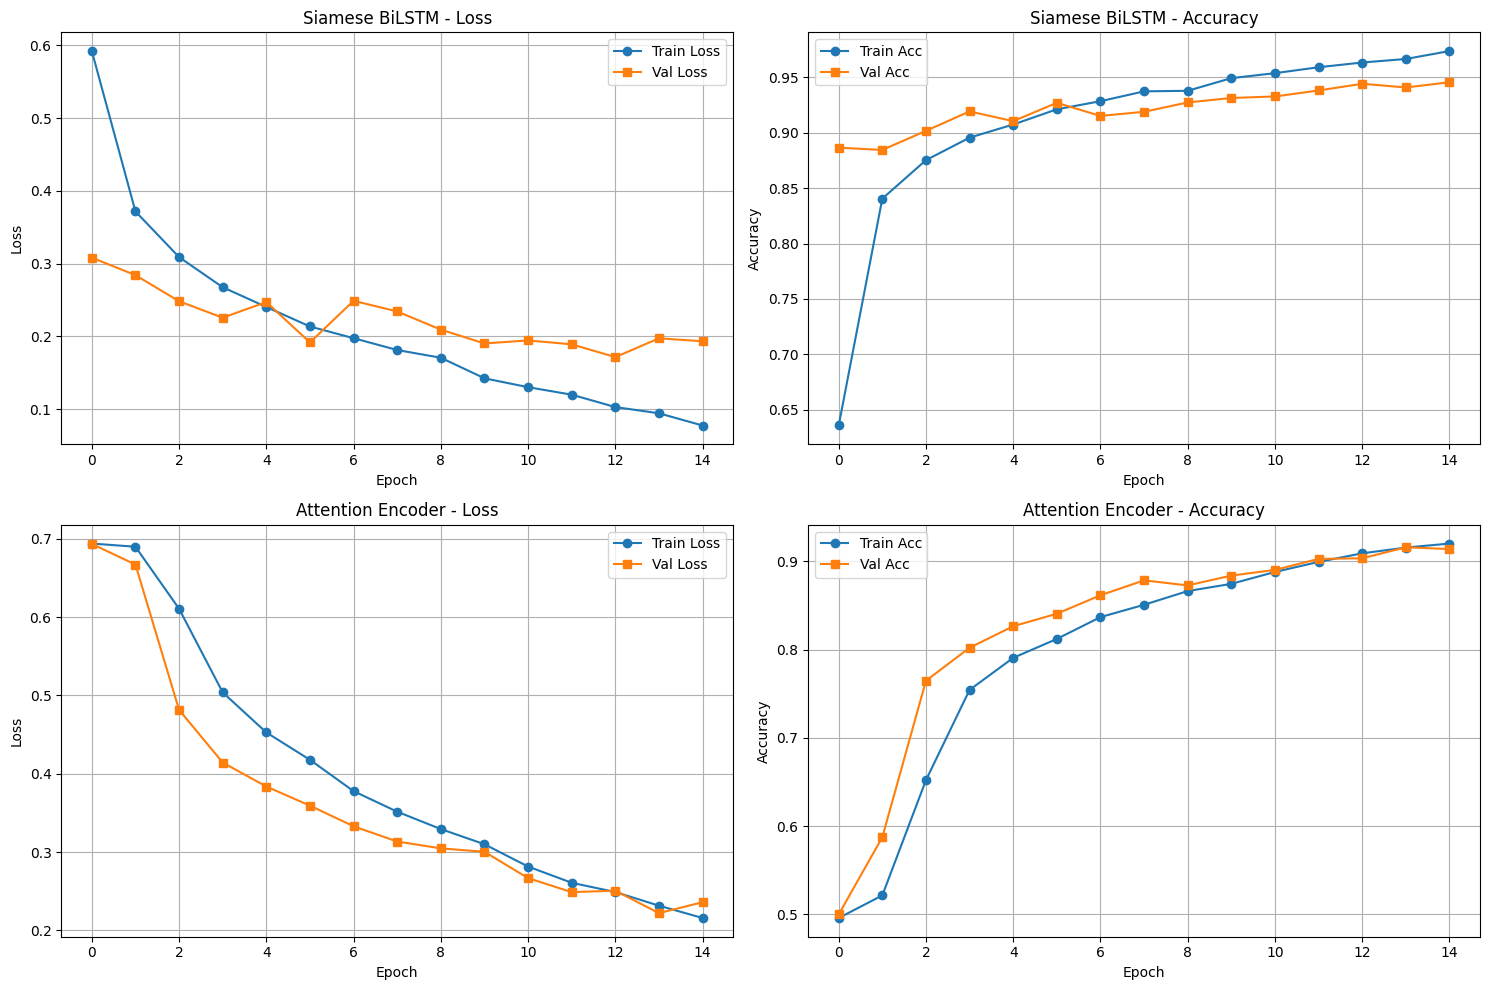

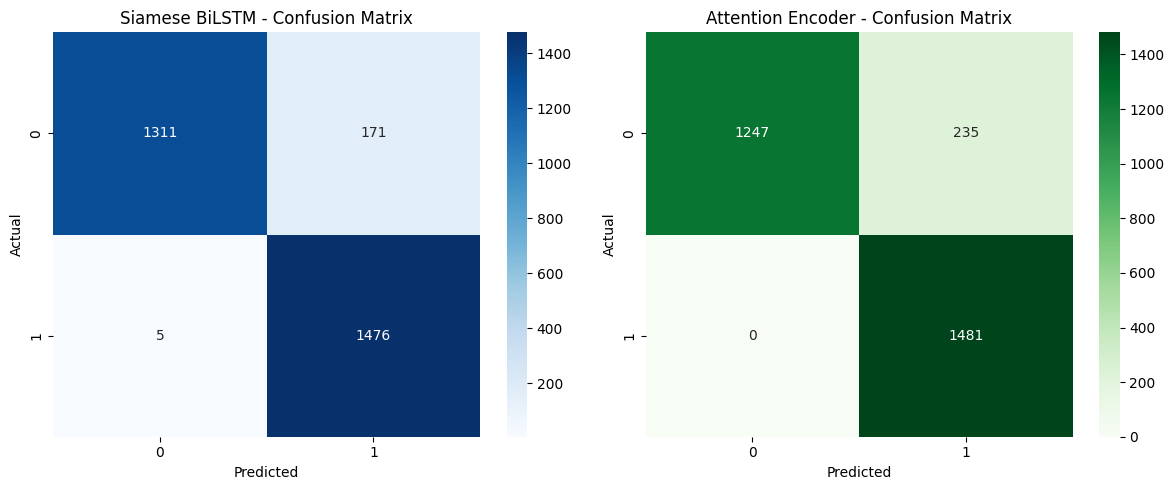

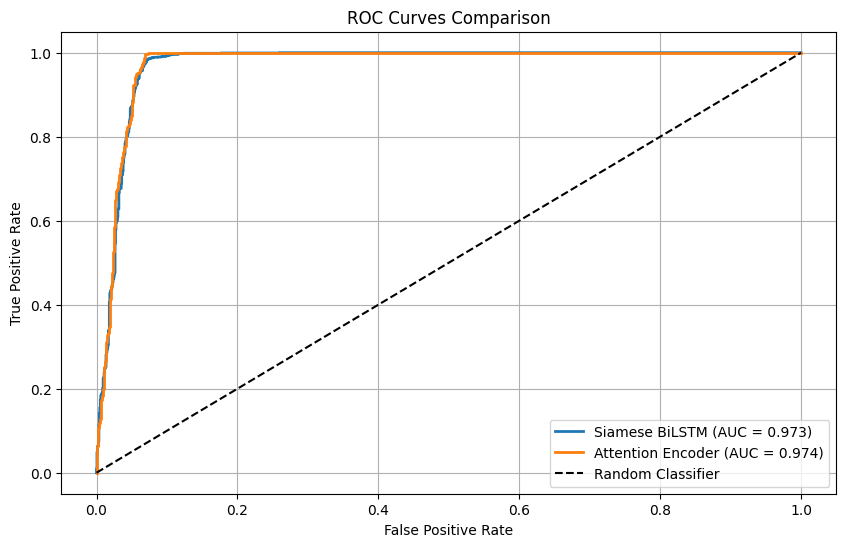


MODEL PERFORMANCE COMPARISON

    Metric  Siamese BiLSTM  Attention Encoder
 Accuracy        0.940601           0.920688
Precision        0.896175           0.863054
   Recall        0.996624           1.000000
 F1-Score        0.943734           0.926494
  ROC-AUC        0.972649           0.974497

Siamese BiLSTM - CORRECT PREDICTIONS

Example 1:
Clause 1: further assurances if at any time after the effective time the surviving corporation shall consider ...
Clause 2: further assurances from time to time as and when required by leslie s delaware or by its successors ...
True Label: 1, Predicted: 1, Confidence: 0.992
--------------------------------------------------------------------------------
Example 2:
Clause 1: inspection subject to confidentiality obligations and similar restrictions that may be applicable to...
Clause 2: inspection so long as enertech owns one percent 1 0 of the issued and outstanding capital stock of t...
True Label: 1, Predicted: 1, Confidence: 0.985
------

In [11]:
# ============================================================================
# SECTION 6: MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""

    # Configuration
    DATA_PATH = '/root/.cache/kagglehub/datasets/bahushruth/legalclausedataset/versions/1'
    BATCH_SIZE = 32
    EMBEDDING_DIM = 128
    HIDDEN_DIM = 128
    NUM_EPOCHS = 15
    LEARNING_RATE = 0.001

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # ========== DATA PREPROCESSING ==========
    print("\n" + "="*80)
    print("STEP 1: DATA LOADING AND PREPROCESSING")
    print("="*80)

    preprocessor = DataPreprocessor(DATA_PATH)
    df = preprocessor.load_data()

    # Build vocabulary
    preprocessor.build_vocab(df['clause_text'].tolist())

    # Create pairs
    pairs_df = preprocessor.create_pairs(df)

    # Split data
    train_df, temp_df = train_test_split(pairs_df, test_size=0.3, random_state=42, stratify=pairs_df['label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

    print(f"\nDataset splits:")
    print(f"  Train: {len(train_df)} pairs")
    print(f"  Val: {len(val_df)} pairs")
    print(f"  Test: {len(test_df)} pairs")

    # Create datasets and dataloaders
    train_dataset = ClausePairDataset(train_df, preprocessor)
    val_dataset = ClausePairDataset(val_df, preprocessor)
    test_dataset = ClausePairDataset(test_df, preprocessor)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # ========== MODEL 1: SIAMESE BiLSTM ==========
    print("\n" + "="*80)
    print("STEP 2: TRAINING SIAMESE BiLSTM MODEL")
    print("="*80)

    model1 = SiameseBiLSTM(
        vocab_size=preprocessor.vocab_size,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM
    )
    print(f"\nModel Architecture:")
    print(model1)
    print(f"\nTotal Parameters: {sum(p.numel() for p in model1.parameters()):,}")

    trainer1 = ModelTrainer(model1, device)
    criterion = nn.BCELoss()
    optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

    history1 = trainer1.train(train_loader, val_loader, criterion, optimizer1, NUM_EPOCHS)

    # Evaluate on test set
    _, test_preds1, test_labels1, test_probs1 = trainer1.evaluate(test_loader, criterion)
    metrics1 = compute_metrics(test_labels1, test_preds1, test_probs1)

    print("\nTest Set Metrics (Siamese BiLSTM):")
    for metric, value in metrics1.items():
        print(f"  {metric.upper()}: {value:.4f}")

    # ========== MODEL 2: ATTENTION ENCODER ==========
    print("\n" + "="*80)
    print("STEP 3: TRAINING ATTENTION-BASED MODEL")
    print("="*80)

    model2 = AttentionEncoder(
        vocab_size=preprocessor.vocab_size,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM
    )

    print(f"\nModel Architecture:")
    print(model2)
    print(f"\nTotal Parameters: {sum(p.numel() for p in model2.parameters()):,}")

    trainer2 = ModelTrainer(model2, device)
    optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

    history2 = trainer2.train(train_loader, val_loader, criterion, optimizer2, NUM_EPOCHS)

    # Evaluate on test set
    _, test_preds2, test_labels2, test_probs2 = trainer2.evaluate(test_loader, criterion)
    metrics2 = compute_metrics(test_labels2, test_preds2, test_probs2)

    print("\nTest Set Metrics (Attention Encoder):")
    for metric, value in metrics2.items():
        print(f"  {metric.upper()}: {value:.4f}")

    # ========== VISUALIZATION AND COMPARISON ==========
    print("\n" + "="*80)
    print("STEP 4: GENERATING VISUALIZATIONS AND COMPARISON")
    print("="*80)

    # Training history
    history1_dict = {
        'train_loss': history1[0],
        'train_acc': history1[1],
        'val_loss': history1[2],
        'val_acc': history1[3]
    }

    history2_dict = {
        'train_loss': history2[0],
        'train_acc': history2[1],
        'val_loss': history2[2],
        'val_acc': history2[3]
    }

    plot_training_history(history1_dict, history2_dict,
                         "Siamese BiLSTM", "Attention Encoder")

    # Confusion matrices
    plot_confusion_matrices(test_labels1, test_preds1,
                           test_labels2, test_preds2,
                           "Siamese BiLSTM", "Attention Encoder")

    # ROC curves
    plot_roc_curves(test_labels1, test_probs1,
                   test_labels2, test_probs2,
                   "Siamese BiLSTM", "Attention Encoder")

    # Comparison table
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)

    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
        'Siamese BiLSTM': [
            metrics1['accuracy'],
            metrics1['precision'],
            metrics1['recall'],
            metrics1['f1'],
            metrics1['roc_auc']
        ],
        'Attention Encoder': [
            metrics2['accuracy'],
            metrics2['precision'],
            metrics2['recall'],
            metrics2['f1'],
            metrics2['roc_auc']
        ]
    })

    print("\n", comparison_df.to_string(index=False))

    # Show examples
    show_examples(test_df.reset_index(drop=True), test_labels1, test_preds1, test_probs1,
                 "Siamese BiLSTM", num_examples=5)
    show_examples(test_df.reset_index(drop=True), test_labels2, test_preds2, test_probs2,
                 "Attention Encoder", num_examples=5)

    print("\n" + "="*80)
    print("TRAINING COMPLETE! All visualizations saved.")
    print("="*80)

if __name__ == "__main__":
    main()